<a href="https://colab.research.google.com/github/khanma1962/Fire_Detection_Faster_RCNN/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calling Libraries

In [2]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os


In [3]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cude')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


Connected to CPU


In [ ]:
%%shell

# Torchvision repo to use some utilities

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

# copy some files to Google colab
cp references/detection/utils.py ../
cp references/detection/transformers.py ../
cp references/detection/engine.py ../


Cloning into 'vision'...
remote: Enumerating objects: 31324, done.
remote: Counting objects: 100% (3867/3867), done.
remote: Compressing objects: 100% (883/883), done.
remote: Total 31324 (delta 3025), reused 3691 (delta 2909), pack-reused 27457
Receiving objects: 100% (31324/31324), 38.44 MiB | 28.05 MiB/s, done.
Resolving deltas: 100% (23641/23641), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version
cp: cannot stat 'references/detection/transformers.py': No such file or directory


# Dataset

In [4]:
# copy google drive files to colab directories
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/ .

train_dir = '/content/data/train/images/'
test_dir  = '/content/data/validation/images/'


In [20]:
#read the .csv box with bounding box details

train_df = pd.read_csv('/content/data/train/mvisionai-7-18-2021.csv')
print(f'Shape of the train df is {train_df.shape}\n')
num_pic = len(train_df['filename'].unique())
print(f'Unique pics are {num_pic}\n')
train_df.head()

Shape of the train df is (563, 8)

Unique pics are 412



,filename,width,height,class,xmin,ymin,xmax,ymax
0,img (31).jpg,295,171,fire,5,40,81,95
1,img (32).jpg,undefined,undefined,fire,63,107,150,166
2,img (33).jpg,undefined,undefined,fire,153,114,218,153
3,img (34).jpg,undefined,undefined,fire,135,87,197,145
4,img (35).jpg,undefined,undefined,fire,206,11,288,73


In [13]:
#extracting x1,y1, x2, and y2 from train_df



412

In [21]:
# checking number of files in train and test
for path, dir, fils in os.walk(train_dir):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(test_dir):
    print(f'{path} has {len(os.listdir(path))}')
# len(os.listdir(test_dir))

/content/data/train/images/ has 412
/content/data/validation/images/ has 90


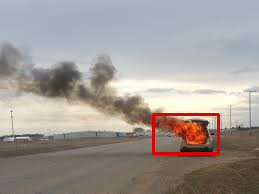

In [71]:
#plot a picture
pic_name = 'img (33).jpg'
image = cv2.imread(train_dir + pic_name)
# window_name = image

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image)


# Pre-trained Model from torchvision


In [ ]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

#get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

#replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

